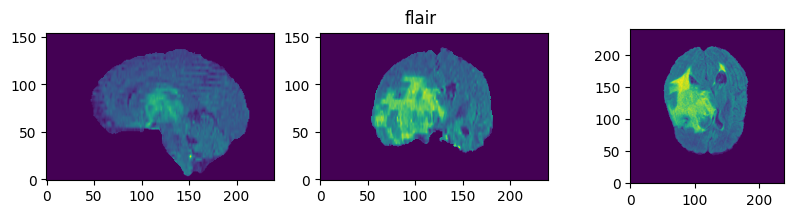

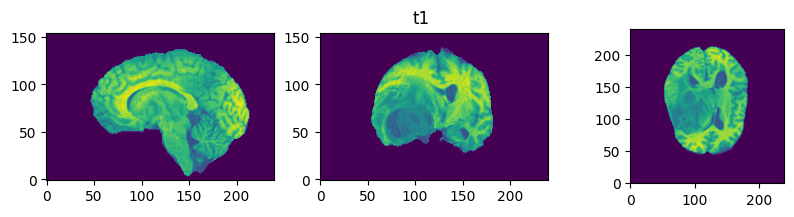

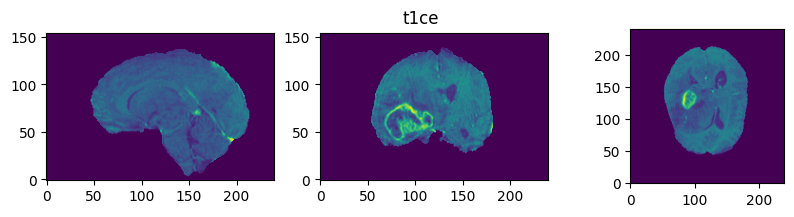

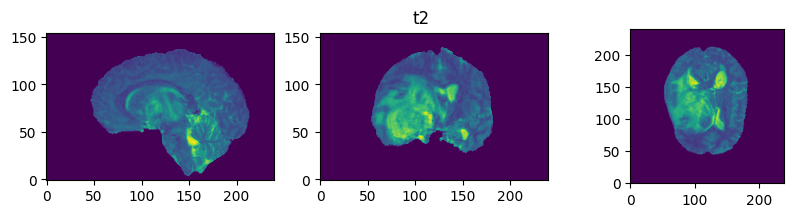

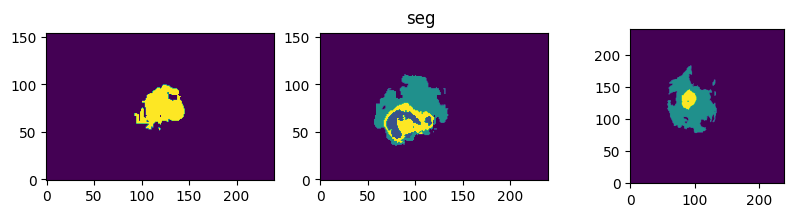

In [37]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt


# Paths to the dataset
training_path = "./brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
validation_path = "./brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

# Load name mapping and survival info
name_mapping_training_path = "./brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/name_mapping.csv"
name_mapping_validation_path = "./brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv"
survival_info_path = "./brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv"
survival_evaluation_path = "./brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv"

# Helper function to load NIfTI files
def load_nifti_file(file_path):
    return nib.load(file_path).get_fdata()

# Helper function to plot MRI slices
def plot_slices(img, title=None):
    slices = [img[img.shape[0]//2, :, :], img[:, img.shape[1]//2, :], img[:, :, img.shape[2]//2]]
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, origin="lower")
    if title:
        fig.suptitle(title)
    plt.show()

# Load sample images
sample_id = "BraTS20_Training_001"  # Example sample ID
modalities = ['flair', 't1', 't1ce', 't2', 'seg']
images = {}

for modality in modalities:
    file_path = os.path.join(training_path, sample_id, f"{sample_id}_{modality}.nii")
    images[modality] = load_nifti_file(file_path)

# Plot sample images
for modality in modalities:
    plot_slices(images[modality], title=modality)

In [21]:
# Check dimensions of the images
for modality in modalities:
    print(f"{modality}: {images[modality].shape}")

flair: (240, 240, 155)
t1: (240, 240, 155)
t1ce: (240, 240, 155)
t2: (240, 240, 155)
seg: (240, 240, 155)


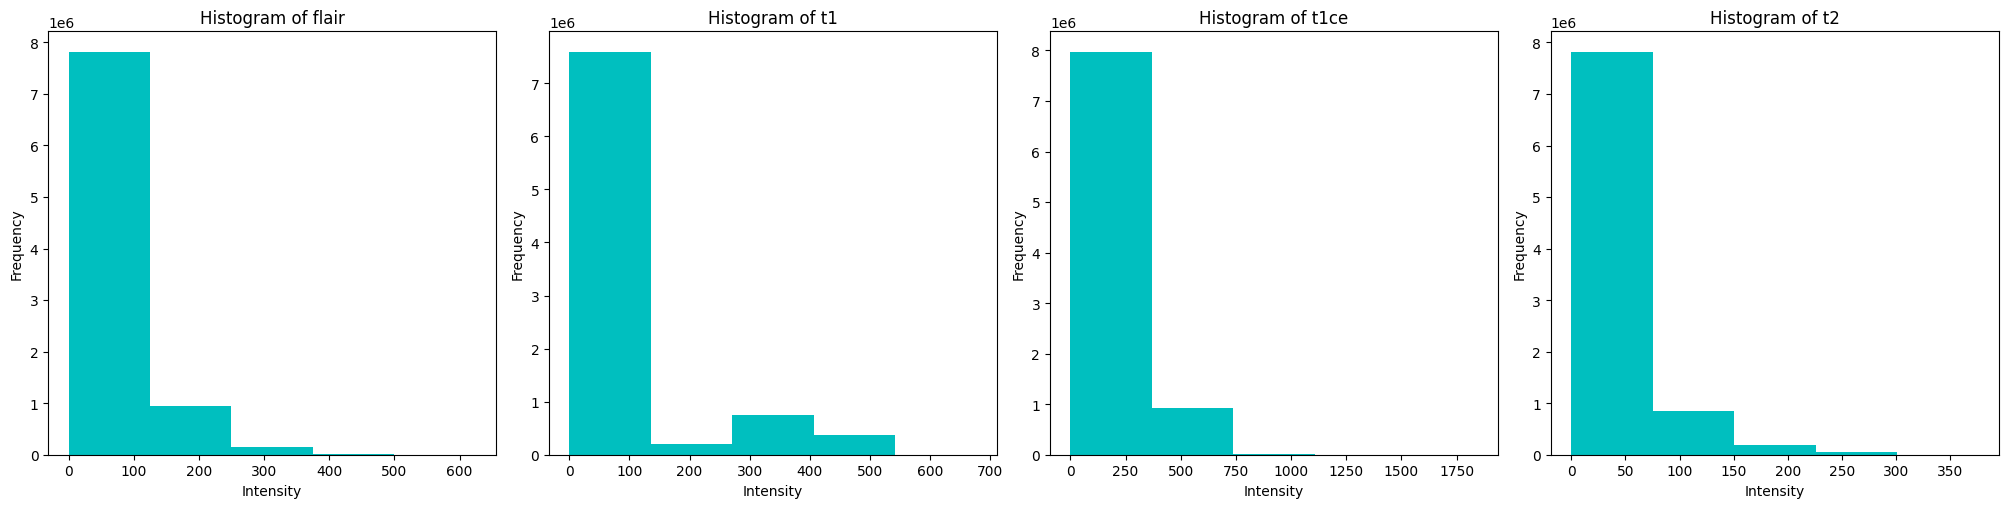

In [22]:
# Plot intensity histograms for each modality
def plot_histogram_row(images_dict):
    fig, axes = plt.subplots(1, len(images_dict), figsize=(20, 5))
    for i, (modality, img) in enumerate(images_dict.items()):
        if modality != 'seg':  # Segmentation mask is categorical, not suitable for intensity histogram
            axes[i].hist(img.flatten(), bins=5, color='c')
            axes[i].set_title(f"Histogram of {modality}")
            axes[i].set_xlabel("Intensity")
            axes[i].set_ylabel("Frequency")
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.5)
    plt.show()

# Plot histograms
plot_histogram_row({modality: images[modality] for modality in modalities if modality != 'seg'})

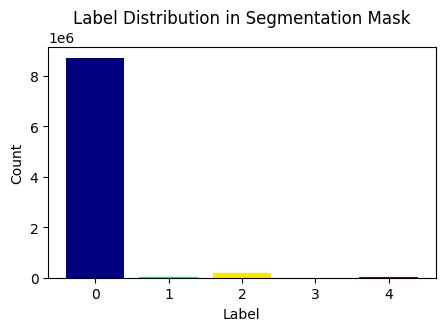

Label counts in segmentation mask:
Label 0.0: 8716021
Label 1.0: 15443
Label 2.0: 168794
Label 4.0: 27742


In [38]:
# Plot label distribution for segmentation masks 
segmentation_labels = images['seg']
unique, counts = np.unique(segmentation_labels, return_counts=True)
plt.figure(figsize=(5, 3))
bars = plt.bar(unique, counts, color=plt.cm.jet(np.linspace(0, 1, len(unique))))
plt.title("Label Distribution in Segmentation Mask")
plt.xlabel("Label")
plt.ylabel("Count")

# # Add text labels on top of bars
# for bar, count in zip(bars, counts):
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval, int(count), va='bottom')  # va: vertical alignment

plt.show()

# Print label counts
print("Label counts in segmentation mask:")
for label, count in zip(unique, counts):
    print(f"Label {label}: {count}")

### Preprocessing : Normalization,Down Sampling,Upsampling, Augmentation

In [24]:
# Select a slice from the sample image
slice_index = 70  # Change this to visualize different slices
original_slices = {modality: images[modality][:, :, slice_index] for modality in modalities}
all_slices = {modality: original_slices[modality] for modality in modalities}
# Segmentation slice
segmentation_slice = images['seg'][:, :,slice_index]

In [26]:
import albumentations as A
from skimage.transform import resize
# Normalize slices to [0, 1] range
def normalize(slice):
    slice_min = np.min(slice)
    slice_max = np.max(slice)
    return (slice - slice_min) / (slice_max - slice_min)
# Resize Images
def resample(image, new_shape):
    return resize(image, new_shape, preserve_range=True, anti_aliasing=True)
# Apply normalization, downsampling, upsampling and augmentation to all modalities
normalized_slices = {modality: normalize(images[modality][:, :, slice_index]) for modality in modalities if modality != 'seg'}
# Normalize segmentation mask
normalized_seg = normalize(images['seg'][:, :, slice_index])
# Apply downsampling to all modalities
downsampled_slices = {modality: resample(images[modality][:, :, slice_index], (120, 120)) for modality in modalities if modality != 'seg'}
# Apply upsampling and augmentation to all modalities
upsampled_slices = {modality: resample(images[modality][:, :, slice_index], (480, 480)) for modality in modalities if modality != 'seg'}
# Define the augmentation pipeline with adjusted parameters
augmentation_pipeline = A.Compose([
    A.Rotate(limit=10, p=1.0),  # Ensured rotation probability
    A.HorizontalFlip(p=0.5),
    A.ElasticTransform(alpha=0.2, sigma=20, alpha_affine=20, p=0.5)  # Reduced elastic transformation parameters
])
# Helper function to apply augmentation
def augment_image(image, mask):
    augmented = augmentation_pipeline(image=image, mask=mask)
    return augmented['image'], augmented['mask']
# Apply augmentation to normalized modalities and segmentation mask
normalized_augmented_slices = {}
normalized_augmented_masks = {}
for modality in modalities:
    if modality != 'seg':
        normalized_img = normalized_slices[modality]
        augmented_img, augmented_mask = augment_image(normalized_img, normalized_seg)
        normalized_augmented_slices[modality] = augmented_img
        normalized_augmented_masks[modality] = augmented_mask

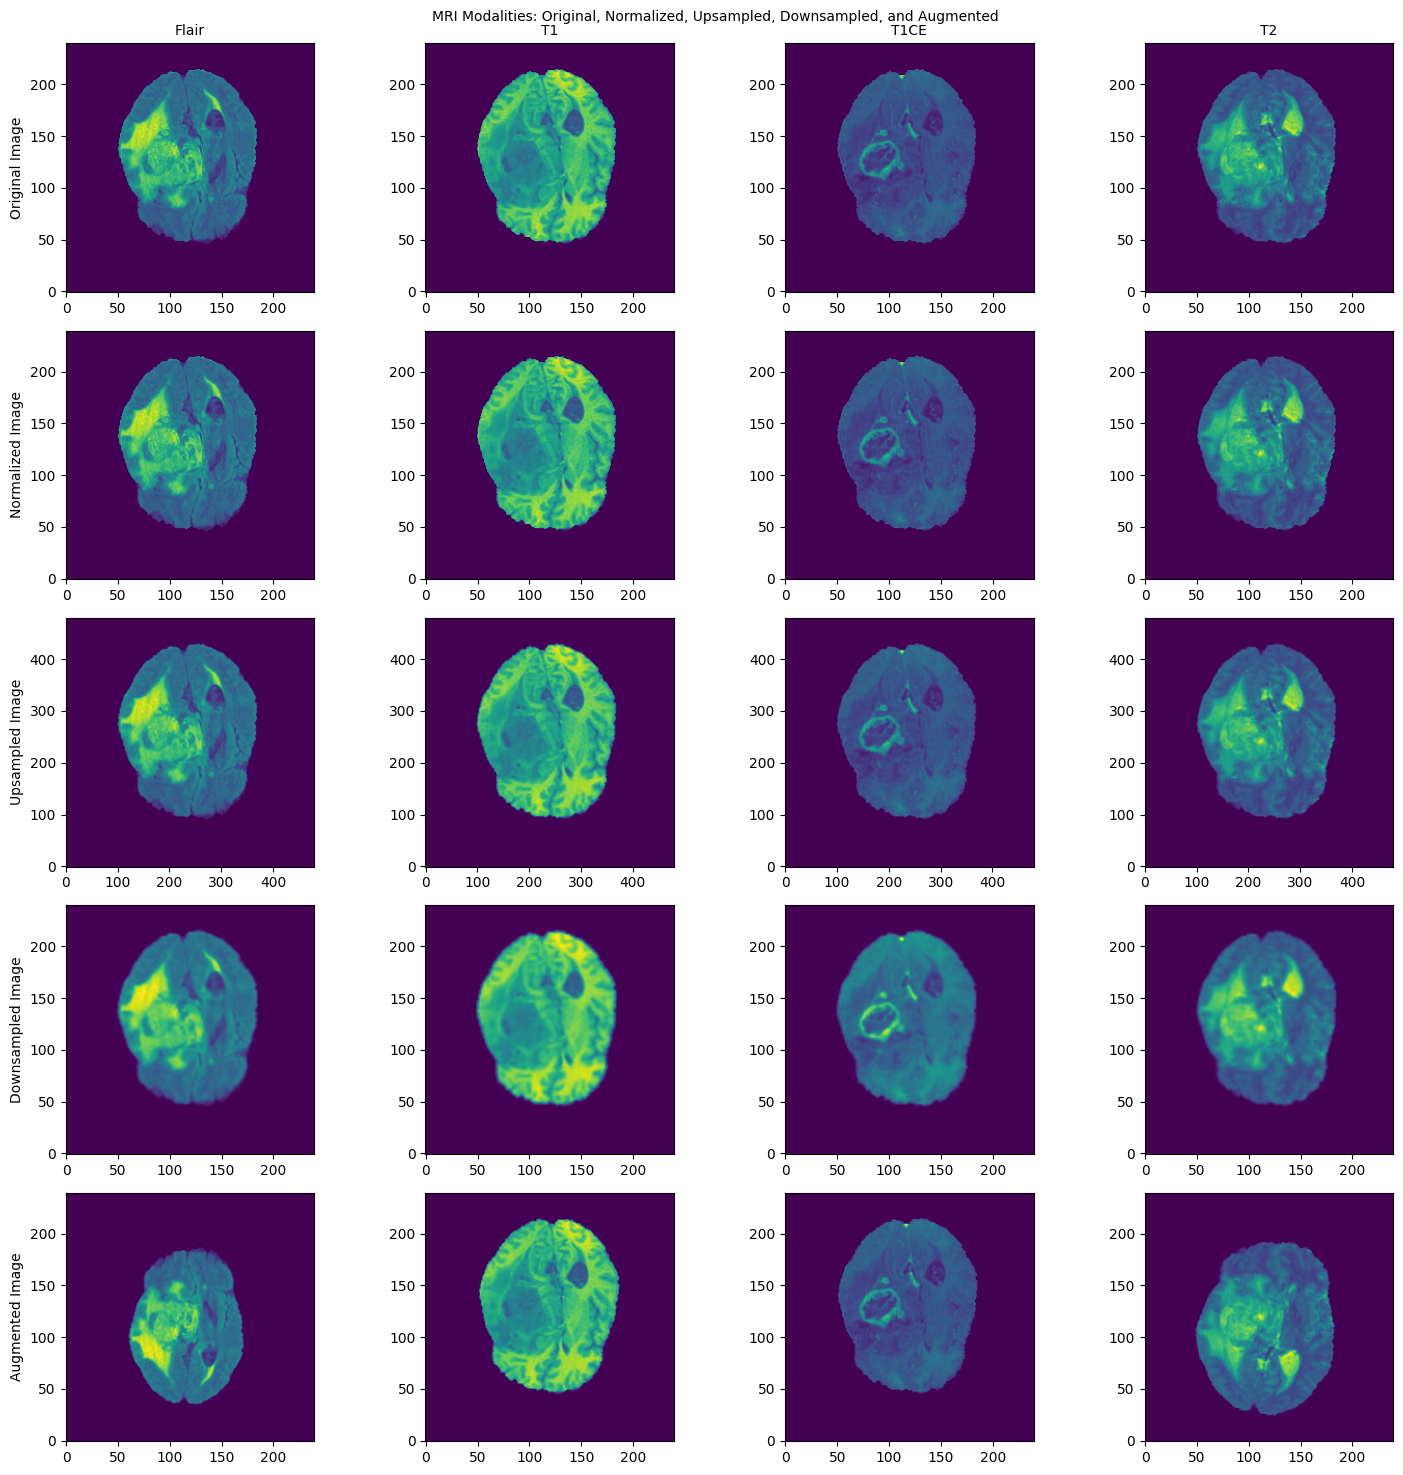

In [30]:
def plot_grid(original_slices, normalized_slices, upsampled_slices, downsampled_slices, augmented_slices):
    fig, axes = plt.subplots(5, len(modalities) - 1, figsize=(15, 15))
    fig.suptitle('MRI Modalities: Original, Normalized, Upsampled, Downsampled, and Augmented', fontsize=10)

    columns = ['Flair', 'T1', 'T1CE', 'T2']
    rows = ['Original Image', 'Normalized Image', 'Upsampled Image', 'Downsampled Image', 'Augmented Image']

    for ax, col in zip(axes[0], columns):
        ax.set_title(col, fontsize=10)

    for ax, row in zip(axes[:, 0], rows):
        ax.set_ylabel(row, rotation=90, fontsize=10)

    for i, modality in enumerate(['flair', 't1', 't1ce', 't2']):
        # Original Images
        axes[0, i].imshow(original_slices[modality].T, origin="lower")
        
        # Normalized Images
        axes[1, i].imshow(normalized_slices[modality].T, origin="lower")
        
        # Upsampled Images
        axes[2, i].imshow(upsampled_slices[modality].T, origin="lower")
        
        # Downsampled Images
        axes[3, i].imshow(resample(downsampled_slices[modality], original_slices[modality].T.shape).T, origin="lower")

        # Augmented Images
        axes[4, i].imshow(normalize(augmented_slices[modality]).T, origin="lower")

    plt.tight_layout()
    plt.show()

# Plot the grid
plot_grid(original_slices, normalized_slices, upsampled_slices, downsampled_slices, normalized_augmented_slices)

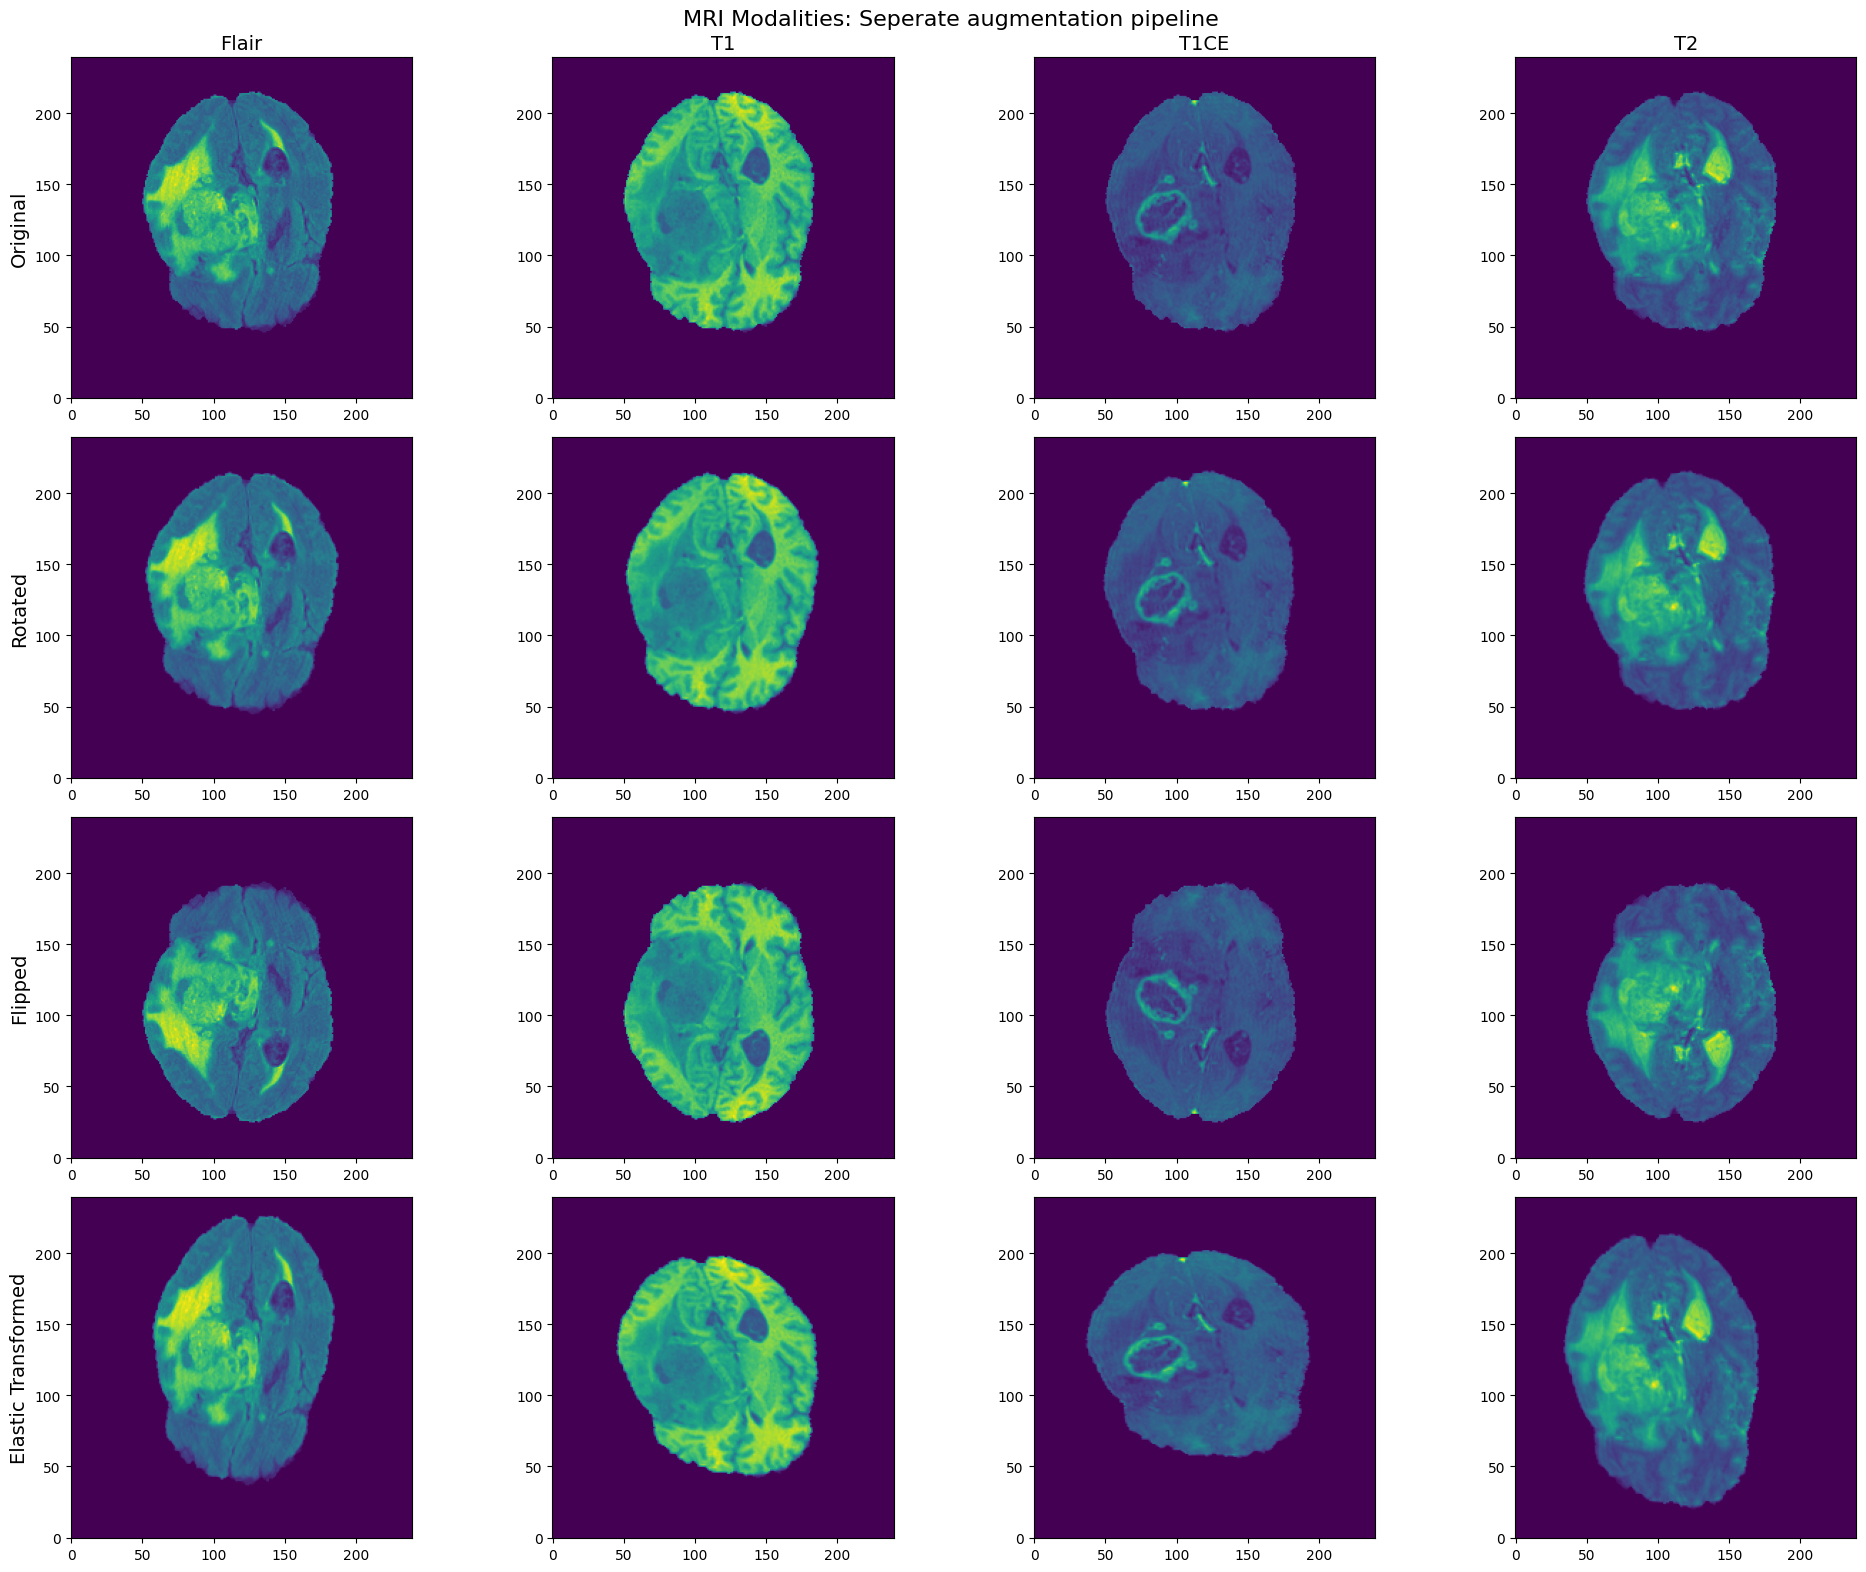

In [31]:
# separate augmentation pipelines 
rotation_pipeline = A.Compose([A.Rotate(limit=10, p=1.0)])
flip_pipeline = A.Compose([A.HorizontalFlip(p=1.0)])
elastic_pipeline = A.Compose([A.ElasticTransform(alpha=0.2, sigma=20, alpha_affine=20, p=1.0)])

# Helper function to apply specific augmentation
def apply_specific_augmentation(image, mask, pipeline):
    augmented = pipeline(image=image, mask=mask)
    return augmented['image'], augmented['mask']

# Function to plot original and augmented images for each modality
def plot_augmented_images(normalized_slices, normalized_seg):
    fig, axes = plt.subplots(4, len(modalities) - 1, figsize=(20, 16))
    fig.suptitle('MRI Modalities: Seperate augmentation pipeline', fontsize=16)

    columns = ['Flair', 'T1', 'T1CE', 'T2']
    rows = ['Original', 'Rotated', 'Flipped', 'Elastic Transformed']

    for ax, col in zip(axes[0], columns):
        ax.set_title(col, fontsize=14)

    for ax, row in zip(axes[:, 0], rows):
        ax.set_ylabel(row, rotation=90, fontsize=14)

    for i, modality in enumerate(['flair', 't1', 't1ce', 't2']):
        normalized_img = normalized_slices[modality]

        # Original Images
        axes[0, i].imshow(normalized_img.T, origin="lower")

        # Rotated Images
        rotated_img, _ = apply_specific_augmentation(normalized_img, normalized_seg, rotation_pipeline)
        axes[1, i].imshow(rotated_img.T, origin="lower")

        # Flipped Images
        flipped_img, _ = apply_specific_augmentation(normalized_img, normalized_seg, flip_pipeline)
        axes[2, i].imshow(flipped_img.T, origin="lower")

        # Elastic Transformed Images
        elastic_img, _ = apply_specific_augmentation(normalized_img, normalized_seg, elastic_pipeline)
        axes[3, i].imshow(elastic_img.T, origin="lower")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Plot the grid
plot_augmented_images(normalized_slices, normalized_seg)

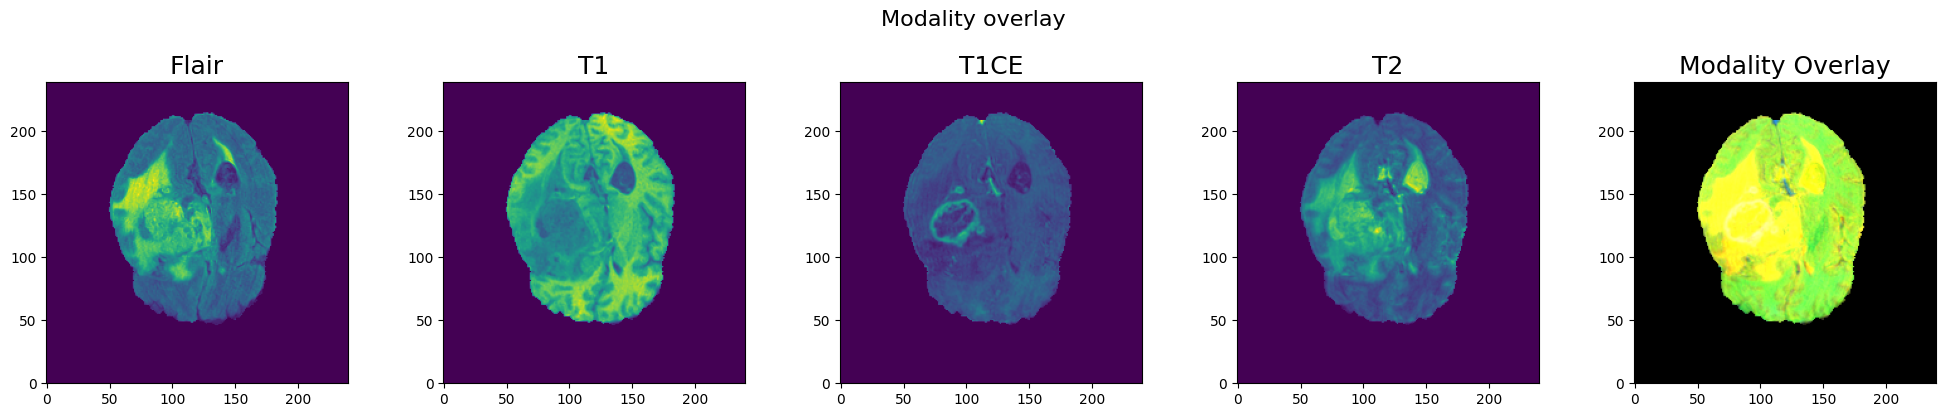

In [65]:
def plot_grid(original_slices):
    fig, axes = plt.subplots(1, len(modalities) - 1 + 1, figsize=(20, 4))
    fig.suptitle('Modality overlay', fontsize=16)

    columns = ['Flair', 'T1', 'T1CE', 'T2', 'Modality Overlay']
    rows = ['Normalized Image with Modality overlay']

    for ax, col in zip(axes, columns):
        ax.set_title(col, fontsize=18)

    for i, modality in enumerate(['flair', 't1', 't1ce', 't2']):
        # Original Images
        axes[i].imshow((original_slices[modality]).T, origin="lower")
    
    # Modality Overlays for Original
    original_overlay = np.zeros((*original_slices['flair'].T.shape, 3))

    for modality, color in zip(['flair', 't1', 't1ce', 't2'], [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0)]):
        slice_original = (original_slices[modality]).T
        
        for j, col in enumerate(color):
            original_overlay[:, :, j] += slice_original * col

    original_overlay = np.clip(original_overlay, 0, 1)

    axes[-1].imshow(original_overlay, origin="lower")

    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    plt.show()

# Plot the grid
plot_grid(normalized_slices)


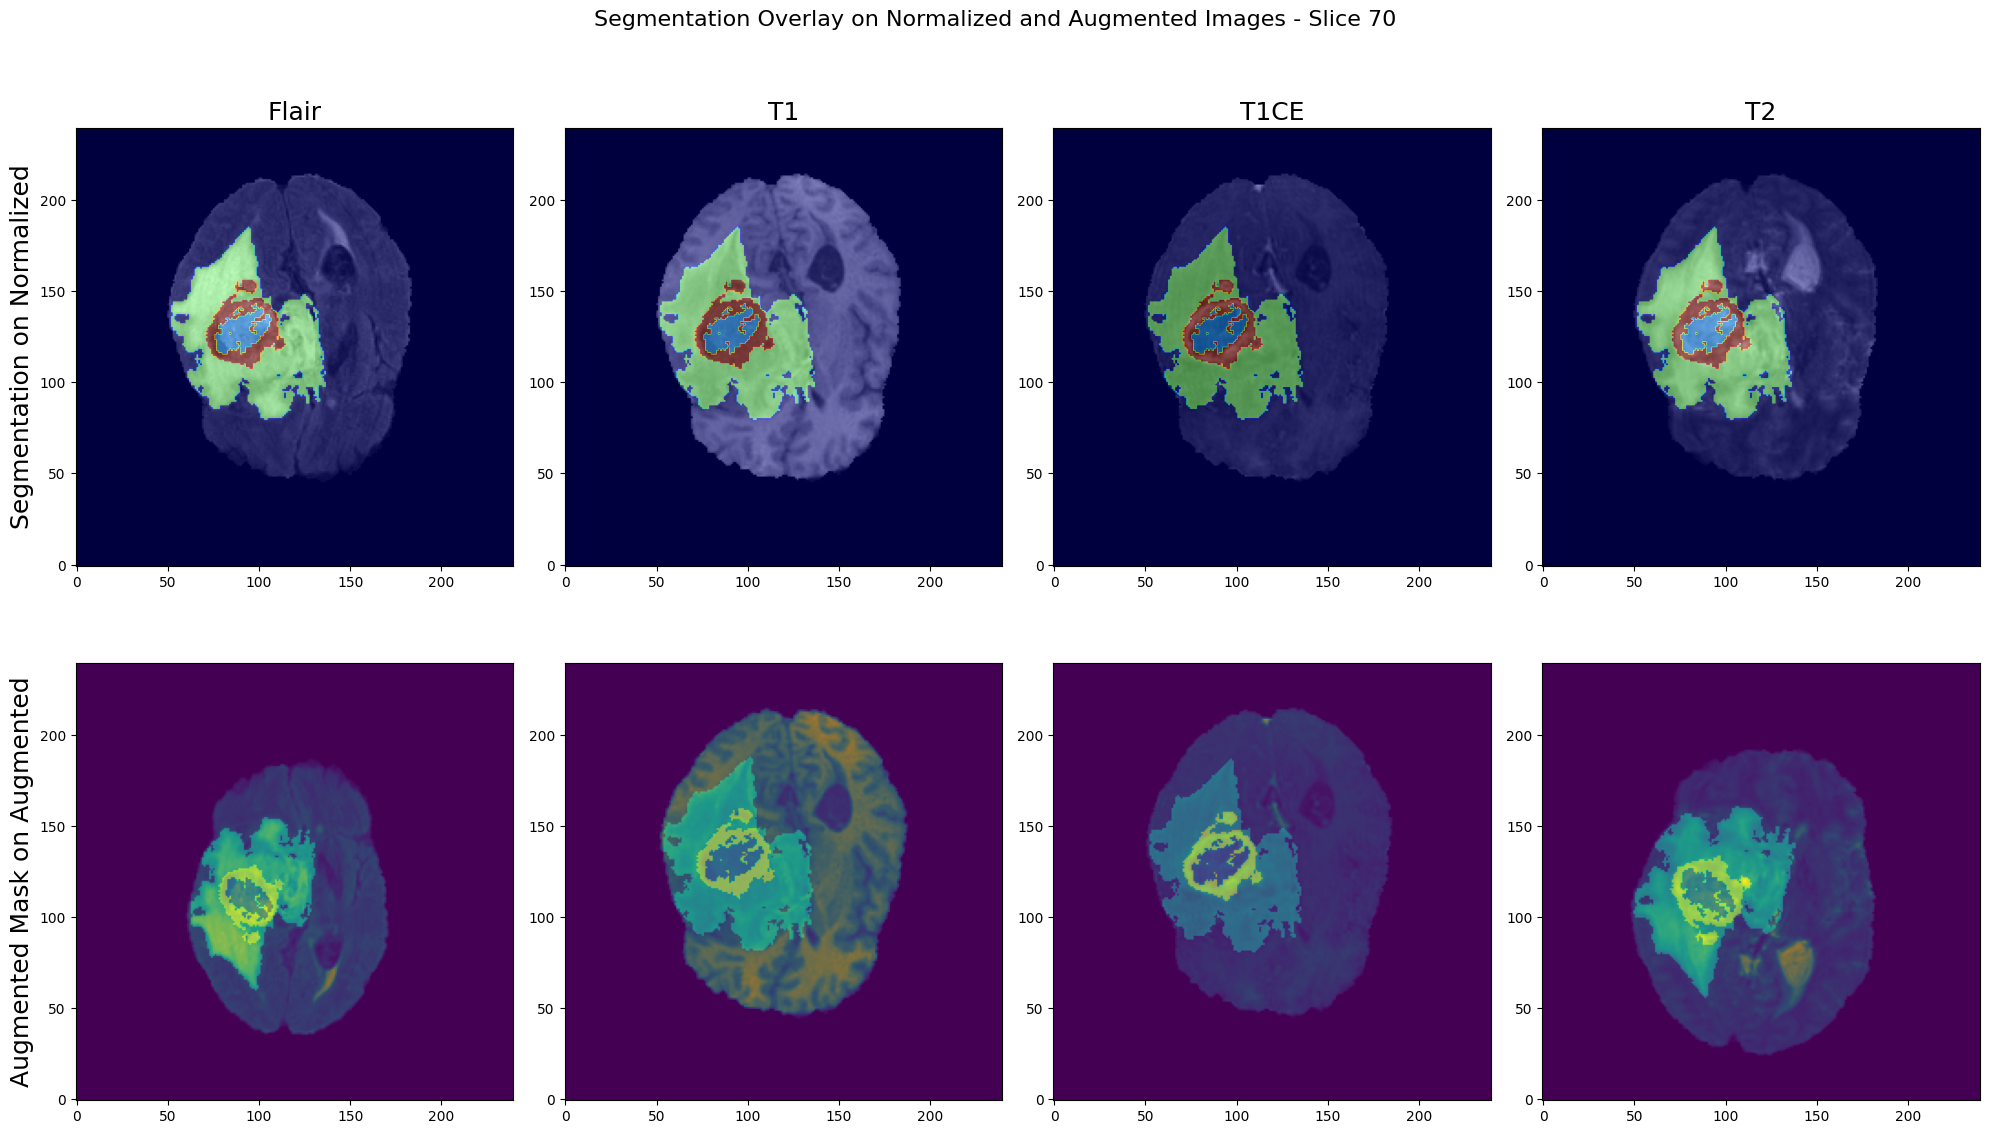

In [35]:
# Function to plot the grid with segmentation overlays
def plot_segmentation_overlay(normalized_slices, augmented_slices, seg_slices, augmented_masks, title):
    fig, axes = plt.subplots(2, len(modalities) - 1, figsize=(20, 12))
    fig.suptitle(title, fontsize=16)

    columns = ['Flair', 'T1', 'T1CE', 'T2']
    rows = ['Segmentation on Normalized', 'Augmented Mask on Augmented']

    for ax, col in zip(axes[0], columns):
        ax.set_title(col, fontsize=18)

    for ax, row in zip(axes[:, 0], rows):
        ax.set_ylabel(row, rotation=90, fontsize=18)

    for i, modality in enumerate(['flair', 't1', 't1ce', 't2']):
        # Segmentation on Normalized Images
        axes[0, i].imshow(normalized_slices[modality].T, cmap="gray", origin="lower")
        axes[0, i].imshow(seg_slices.T, alpha=0.5, origin="lower", cmap="jet")
        
        # Augmented Mask on Augmented Images
        axes[1, i].imshow(augmented_slices[modality].T, origin="lower")
        axes[1, i].imshow(augmented_masks[modality].T, alpha=0.5, origin="lower")

    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

# Plot the grid
plot_segmentation_overlay(normalized_slices, normalized_augmented_slices, normalized_seg, normalized_augmented_masks, 'Segmentation Overlay on Normalized and Augmented Images - Slice 70')